# Извлечение аббревиатур

Извлечение происходит двухэтапно:
1. Сначала "наивно" достаются все аббревиатуры по следущим правилам:
    + Если больше половины букв в слове - заглавные, то это аббревиатура
    + Исключение это возможные инициалы сотрудинков ("М.П.", "М.П" и тп)
    + Потом эти аббревиатуры чистятся - оставляем только буквы и знаки "-", "."

2. Приводим аббревиатуры в одинаковый вид, разделяем аббревиатуры

    После первого этапа остаются аббревиатуры, которые могут писаться несколькими способами - "ЭХО-КГ", "ЭХОКГ", а также "слипленные": "ЛЖ.МР" -> ["ЛЖ", "МР"].

    Поэтому мы будем убирать знаки препинания и смотреть, есть ли такое слово в словаре достанным из текстов "наивно".
    Если нет, то будем разделять по знакам препинания и смотреть, есть ли самостоятельная аббревиатура в словаре

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
with open('../data/all_anamnesises.txt') as f:
    anamnesises = f.read().split('\n\t')

In [3]:
records_df = pd.read_csv('../data/patient_records.csv', sep='\t')

In [4]:
records_df.head()
records_df.dropna(inplace=True)

In [5]:
anamnesises = records_df['record']

In [6]:
def is_abbreviation(word):
    """
    Будем считать аббревиатурами слова, половина букв которого - заглавные
    
    Уберем случаи, когда это может инициалы сотрудника
    """
    
    # убрать инициалы
    if re.fullmatch(r'[A-ZА-Я]\.[A-ZА-Я]\.?', word):
        return False
    
    upper_count = sum([l.isupper() for l in word])
    
    return upper_count > len(word) // 2 and len(word) > 1

def clean_abbr(word):
    """
    Убираем все символы кроме буквенных, точки и тире
    """
    word = re.sub(r'[^A-ZА-Яа-я-a-z-\.]', '', word)
    
    
    while word[-1] in ['-', '.']:
        word = word[:-1]
        
    while word[0] in ['-', '.']:
        word = word[1:]
        
    return word.upper()

# Первый этап
def naive_extract_abbreviation(text):
    text = text.replace(',', ' ')
    abbrs = filter(lambda word: is_abbreviation(word), text.split())
    abbrs = map(clean_abbr, abbrs)
    
    return list(abbrs)

def split_abbreviations(abbr):
    # Если без знаков препинания является аббревиатурой
    # ЭХО-КГ -> ЭХОКГ
    
    if re.sub(r'[\.|-]', '', abbr) in abbrs_counter:
        return [re.sub(r'[\.|-]', '', abbr)]
    
    items = re.split(r'[-\.]', abbr)
    
    new_abbrs = []
    found = False
    
    for item in items:
        if item in abbrs_counter:
            new_abbrs.append(item)

    if len(new_abbrs) > 0:
        return new_abbrs

    return [abbr]


Посмотрим какие аббревиатуры были получены

In [7]:
from collections import Counter

In [8]:
abbrs_counter = Counter()

for text in anamnesises:
    abbrs_counter.update(naive_extract_abbreviation(text))

In [9]:
len(abbrs_counter)

37196

Есть еще некоторые полные слова "ЗАБОЛЕВАНИЯ", "ЖАЛОБЫ", "ДИАГНОЗ"

In [10]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [11]:
# Вспомогательные функции

def find_text_with_abbr(abbr, to_print=False):
    for text in anamnesises:
        if abbr in naive_extract_abbreviation(text):

            text = text.replace(abbr, bcolors.FAIL + abbr + bcolors.ENDC)

            
            return text
        
def find_text_with_chars(abbr):
    for text in anamnesises:
        if abbr in text:
            print(text.replace(abbr, bcolors.FAIL + abbr + bcolors.ENDC))
            return text

In [12]:
# Второй этап: разделение и приведение к одному виду аббревиатур

def extract_abbreviation_from_text(text):
    abbreviations = naive_extract_abbreviation(text)
    items = []
    
    for abbr in abbreviations:
        items.extend(split_abbreviations(abbr))
    
    return items

In [13]:
extract_abbreviation_from_text('ЗМЖВ-ПКА ЭХОКГ ЭХО-КГ')

['ЗМЖВ', 'ПКА', 'ЭХОКГ', 'ЭХОКГ']

Посмотрим сколько всего аббревиатур сейчас получится

In [14]:
abbrs_counter_q = Counter()

for text in anamnesises:
    abbrs_counter_q.update(extract_abbreviation_from_text(text))

In [15]:
len(abbrs_counter_q)

27196

In [16]:
from importlib import reload
import recomendations.word_entropy

In [17]:
reload(recomendations.word_entropy)

<module 'recomendations.word_entropy' from '/Users/michil/medicine_notebooks/abbreviations/abbr_extraction/recomendations/word_entropy.py'>

In [18]:
from recomendations.word_entropy import WordEntropyCounter

In [19]:
wec = recomendations.word_entropy.WordEntropyCounter.from_file('recomendations/war_and_piece.wec')

In [20]:
import re

['z']

In [55]:
abbr_freq = dict()

for n_abbr in abbrs_counter_q:
    abbr = n_abbr.lower()
    
    if re.findall('[a-z]', abbr):
        continue
        
    abbr = ' ' + re.sub(r'[^а-я]', '', abbr) + ' '
    
    if len(abbr) < 2:
        continue
        
    try:
        abbr_freq[(abbr, n_abbr)] = wec.word_entropy(abbr)
    except:
        pass

In [56]:
entryopy_large_words = list(filter(lambda x: abbr_freq[x] < 0.77, abbr_freq.keys()))

In [58]:
find_text_with_abbr('ААААААААААААА')

'  Контроль глюкозы. Консультация психотерапевта (контроль терапии) Контроль АД. Дуплекс БЦА КОНТРОЛЬ ВЫДОХА ен менее 20 сек, находится на свежем воздухе больше, ДЫШАТЬ С ПОЛНЫМ ВЫДОХОМ!!!!!!! Тянуть звук \x1bААААААААААААА\x1b больше 20 сек. Кортексин в/м курс 10 во второй половине дня. Фенибут 250 мг по 1 таб 3 раза в день, курс 3 недели. Циннаризин (сугерон )25 мг по 1 таб 3 раза в день, курс 2 месяца.     '

In [63]:
print(find_text_with_abbr('ГАЗ', to_print=True))

'3 споласкивание горла минеральными водами-Нарзан,Ессентуки /\x1bГАЗ\x1b ВЫВЕТРИТЬ/2-3 глотка -3-8 раза в день'

In [65]:
print(find_text_with_abbr('ЯЙЦО', to_print=True))

   Постепенное расширение пищевого рациона с увеличением объема жидкой пищи и овощей. Избегать жирной, острой пищи Есть до 6 раз в день мелкими порциями Наблюдение кардиолога и гастроэнтеролога ПРОДОЛЖИТЬ ПОСТОЯННЫЙ ПРИЕМ:  ДИОВАН 80 МГ УТРОМ И ВЕЧЕРОМ ДИЛАТРЕНД 6,25 МГ УТРОМ И ВЕЧЕРОМ АРИФОН-РЕТАРД 1,5 МГ УТРОМ   ПАРИЕТ 20 МГ ЗА 30 МИНУТ ДО ЗАВТРАКА 1 НЕДЕЛЮ, ЗАТЕМ ПО 10 МГ ЗА 30 МИНУТ ДО ЗАВТРАКА 2 МЕСЯЦА  ДЕ-НОЛ ЧЕРЕЗ 1 ЧАС ПОСЛЕ ЗАВТРАКА, ОБЕДА, УЖИНА И НА НОЧЬ 1 МЕСЯЦ  КРЕОН 10000 ЕД В КАЖДЫЙ ПРИЕМ ПИЩИ, А ЕСЛИ УПОТРЕБЛЯЕТСЯ БЕЛКОВАЯ ПИЩА (МЯСО, РЫБА, ТВОРОГ, ЯЙЦО), ТО 25000 ЕД (СУММАРНО ЗА СУТКИ 80000-100000 ЕД)  ПРИ ВЗДУТИИ ЖИВОТА ПЕКСАН-R      


In [66]:
print(find_text_with_abbr('РОД'))

1. Наблюдение гематолога/онколога, терапевта, кардиолога, невролога, хирурга, сосудистого хирурга, ревматолога в поликлинике по месту жительства. 2. Контроль клинического анализа крови + лейкоцитарная формула — 1 раз в 2 недели 3. Контроль биохимического анализа крови (АЛТ, АСТ, креатинин, мочевина, мочевая кислота, натрий, калий, глюкоза, билирубин, СРБ) — 1 раз в 2 недели 4. Учитывая наличие первичной лимфомы ЦНС с многофокусным поражением головного мозга, отсутствие оптимального ответа на фоне таргетной терапии и отсутствие возможности проведения высокодозной химиотерапии, показано проведение тотального облучения головного мозга (WBRT). Рекомендуемая СОД 36Гр и РОД 1.8-2.0 Гр. В дальнейшем показано проведение рестадирования заболевания, МРТ головного мозга с в/в контрастированием через 1 мес после окончания радиотерапии. При сохранении опухолевого объема с накоплением контрастного препарата, решение вопроса о локальном облучении. 5. Консультация радиолога в кратчайшие сроки.  6. Рес

In [59]:
sorted([(word, abbr_freq[word]) for word in entryopy_large_words], reverse=True)

[((' ячтв ', 'ЯЧТВ'), 0.7581254059386007),
 ((' ячвка ', 'ЯЧВКА'), 0.7427399743369312),
 ((' яхно ', 'ЯХНО'), 0.7518101831474199),
 ((' ятфн ', 'ЯТФН'), 0.33699271611289905),
 ((' ясны ', 'ЯСНЫ'), 0.7174207706393622),
 ((' янв ', 'ЯНВ'), 0.3199833988910689),
 ((' ямрт ', 'ЯМРТ'), 0.3663795328607049),
 ((' ямр ', 'ЯМР'), 0.21876724480401943),
 ((' яка ', 'ЯКА'), 0.7192819755318457),
 ((' яйцо ', 'ЯЙЦО'), 0.6010588334386646),
 ((' яйца ', 'ЯЙЦА'), 0.6751746024372807),
 ((' яибс ', 'ЯИБС'), 0.15855314999885878),
 ((' языке ', 'ЯЗЫКЕ'), 0.7373595281961356),
 ((' язык ', 'ЯЗЫК'), 0.6122770524829642),
 ((' язж ', 'ЯЗЖ'), 0.2612152871004578),
 ((' язвк ', 'ЯЗВК'), 0.6163195469865728),
 ((' язв ', 'ЯЗВ'), 0.5252990040838832),
 ((' яг ', 'ЯГ'), 0.19237671019779623),
 ((' явке ', 'ЯВКЕ'), 0.4859920091748347),
 ((' явкас ', 'ЯВКАС'), 0.6828112289678228),
 ((' явк ', 'ЯВК'), 0.3609095334616633),
 ((' яв ', 'ЯВ'), 0.26988899055897386),
 ((' ябж ', 'ЯБЖ'), 0.06766027759724326),
 ((' ябдпк ', 'ЯБДПК'

In [38]:
len(pd.Series(entryopy_large_words))

4658

In [41]:
with open('abbreviations_by_entropy.txt', 'w') as f:
    f.write("\n".join(entryopy_large_words))

In [102]:
import numpy as np

In [103]:
np.median(list(abbr_freq.values()))

0.19104665877054913

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(3.799999999999997, 0.5, 'Count')

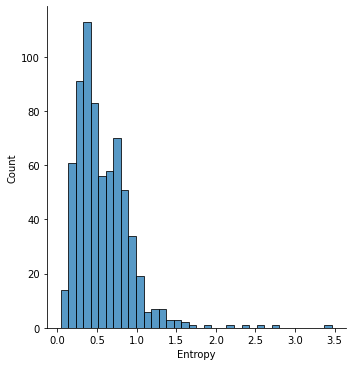

In [193]:
sns.displot(abbr_freq.values(), legend=False)
plt.xlabel('Entropy')
plt.ylabel('Count')

In [111]:
import matplotlib.pyplot as plt

Уменьшилось на 100 аббревиатур: исчезли слипленные единичные аббревиатуры и были приведены к одному виду некоторые аббревиатуры

## Сокращения, не написанные заглавными буквами

(Пока не доделано)

In [217]:
def can_be_sokr_by_sep(word, sep='.'):
    if sep in word:
        return all([can_be_sokr_by_sep(subword, sep) for subword in word.split(sep)])
    
    if len(word) == 0:
        return True
    
    if word[-1] in ['а', 'у', 'о', 'ы', 'и', 'э', 'я', 'ю', 'ё', 'е']:
        if len(word) == 1:
            return True
    else:
        if len(word) <= 6:
            return True
        
    return False

In [218]:
right_sokr = Counter()
clean_sokr = dict()

for text in anamnesises:
    for word in text.split():
        if re.findall(r'\d', word) or re.fullmatch(r'[А-Я]\.[А-Я].*', word):
            continue
            
        if not re.findall(r'[A-ZА-Яa-zа-я]+[\.|/][A-ZА-Яa-zа-я]+[\.|/]*', word):
            continue
            
        if ('.' in word or '/' in word) and (can_be_sokr_by_sep(word, '.') or can_be_sokr_by_sep(word, '/')) and not is_abbreviation(word):
            right_sokr.update([clean_sokr.get(clean_abbr(word), word)])
            
            if not clean_abbr(word) in clean_sokr:
                clean_sokr[clean_abbr(word)] = word

In [219]:
len(right_sokr)

287

In [157]:
find_text_with_chars('Г.КИРИШИ;')

  Дебют ИБС с ОИМ в 2007 г. АКШ в 2008 г. С 07:00.07.10.15. впервые за длительный период давящая боль за грудиной, потливость. Вызвал с/пом. был госпитализирован в Киришскую ЦРБ с д-зом Повт ОИМ нижне-боковой ст ЛЖ от 07.10.15.   Повышение АД: Давность с 55 лет: максимальное 180/100 мм рт cт; "рабочее" 145/90 мм рт cт; на постоянной гипотензивной терапии аккупро   Сахарный диабет,, БА, заболевания ЩЖ: отрицает   Инфаркт миокарда: Инфаркт миокарда: 2007 гг; Эндоваскулярные вмешательства/АКШ: 2008   Госпитализация по поводу данного заболевания: Последняя госпитализация дата: 07.10.2015, Срок госпитализации: 1 сутки; лечебное учреждение: МУЗ "ЦРБ", Г.КИРИШИ; Проводимое лечение: гепарин. морфин, аспирин, плавикс 300 мг нитроминт   Переведен в ФМИЦ для КШГ.   


'  Дебют ИБС с ОИМ в 2007 г. АКШ в 2008 г. С 07:00.07.10.15. впервые за длительный период давящая боль за грудиной, потливость. Вызвал с/пом. был госпитализирован в Киришскую ЦРБ с д-зом Повт ОИМ нижне-боковой ст ЛЖ от 07.10.15.   Повышение АД: Давность с 55 лет: максимальное 180/100 мм рт cт; "рабочее" 145/90 мм рт cт; на постоянной гипотензивной терапии аккупро   Сахарный диабет,, БА, заболевания ЩЖ: отрицает   Инфаркт миокарда: Инфаркт миокарда: 2007 гг; Эндоваскулярные вмешательства/АКШ: 2008   Госпитализация по поводу данного заболевания: Последняя госпитализация дата: 07.10.2015, Срок госпитализации: 1 сутки; лечебное учреждение: МУЗ "ЦРБ", Г.КИРИШИ; Проводимое лечение: гепарин. морфин, аспирин, плавикс 300 мг нитроминт   Переведен в ФМИЦ для КШГ.   '

## Визуализация

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

In [538]:
values = pd.Series(list("".join(abbrs_counter.keys()))).value_counts()

In [539]:
values = values.sort_index()

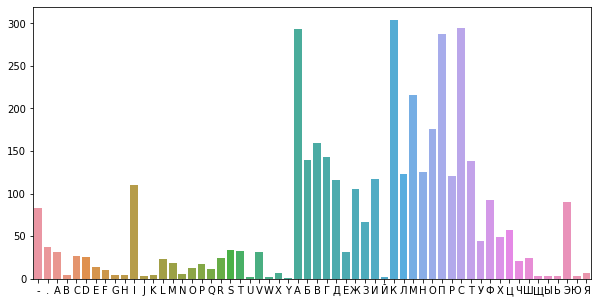

In [540]:
plt.figure(figsize=(10, 5))
sns.barplot(x=values.index, y=values.values)

In [55]:
abbreviations_decodes = {
    'АД': 'Артериальное давление',
    'ПМЖА': 'Передняя межжелудочковая артерия',
    'КАГ': 'Коронарная ангиография',
    'ПКА': 'Правая коронарная артерия',
    'ЭКГ': 'Электрокардиография',
    'ИМ': 'Инфаркт миокарда',
    'ОА': 'Огибающая артерия',
    'ЛЖ': 'Левый желудок',
    'ИБС': 'Ишемическая болезнь сердца',
    'ГБ': 'Гипертоническая болезнь',
    'РТСА': 'Перкутанная транслюминальная коронарная ангиопластика',
    'ПКА': 'Правая коронарная артерия',
    'СМП': 'Скорая медицинская помощь',
    'ФВ': 'Фракция выброса',
    'ОНМК': 'Острое нарушение мозгового кровообращения',
    'ОИМ': 'Острый инфаркт миокарда',
    'ДА': 'Диагональная артерия',
    'ЭХОКГ': 'Эхокардиография',
    'ОКС': 'Острый коронарный синдром',
}